In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import altair as alt
from plotnine import *
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [3]:
# load in pre-cleaned deaths data for Washington and comparison states
deaths = pd.read_csv("05_cleaned_data/deaths_wa.csv")


In [4]:
deaths

,County,County Code,Year,Year Code,Drug/Alcohol Induced Cause,Drug/Alcohol Induced Cause Code,Deaths,State,StateFIPS,CountyName,StateName,CountyFIPS,StateAbbr,STATE_COUNTY,state_abbrev,FIP_unique,Population,county_test
0,Ada,16001.0,2009.0,2009.0,Drug poisonings (overdose) Unintentional (X40-...,D1,34.0,ID,16,Ada,Idaho,16001,ID,ID | ADA,ID,1600116,388577.0,Ada
1,Ada,16001.0,2009.0,2009.0,Drug poisonings (overdose) Suicide (X60-X64),D2,10.0,ID,16,Ada,Idaho,16001,ID,ID | ADA,ID,1600116,388577.0,Ada
2,Ada,16001.0,2009.0,2009.0,All other alcohol-induced causes,A9,32.0,ID,16,Ada,Idaho,16001,ID,ID | ADA,ID,1600116,388577.0,Ada
3,Ada,16001.0,2009.0,2009.0,All other non-drug and non-alcohol causes,O9,2197.0,ID,16,Ada,Idaho,16001,ID,ID | ADA,ID,1600116,388577.0,Ada
4,Ada,16001.0,2010.0,2010.0,Drug poisonings (overdose) Unintentional (X40-...,D1,35.0,ID,16,Ada,Idaho,16001,ID,ID | ADA,ID,1600116,393354.0,Ada
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2206,Treasure,30103.0,2011.0,2011.0,All other non-drug and non-alcohol causes,O9,11.0,MT,30,Treasure,Montana,30103,MT,MT | TREASURE,MT,3010330,713.0,Treasure
2207,Treasure,30103.0,2014.0,2014.0,All other non-drug and non-alcohol causes,O9,14.0,MT,30,Treasure,Montana,30103,MT,MT | TREASURE,MT,3010330,689.0,Treasure
2208,Treasure,30103.0,2015.0,2015.0,All other non-drug and non-alcohol causes,O9,12.0,MT,30,Treasure,Montana,30103,MT,MT | TREASURE,MT,3010330,684.0,Treasure
2209,Clark,16033.0,2012.0,2012.0,All other non-drug and non-alcohol causes,O9,12.0,ID,16,Clark,Idaho,16033,ID,ID | CLARK,ID,1603316,884.0,Clark


In [5]:
# two separate dfs - one for washington and one for comp states

washington = deaths[deaths["StateName"] == "Washington"]
comp = deaths[deaths["StateName"] != "Washington"]

### Helper functions 

In [7]:
# function to select only overdose records
# double check this

def select_overdose(record):
    """Simple function to select only overdose records"""

    if record == "All other non-drug and non-alcohol causes":
        return 0

    if record == "All other alcohol-induced causes":
        return 0

    if record == "All other drug-induced causes":
        return 0

    if record == "Alcohol poisonings (overdose) (X45, X65, Y15)":
        return 0

    if record == "Drug poisonings (overdose) Unintentional (X40-X44)":
        return 1

    if record == "Drug poisonings (overdose) Suicide (X60-X64)":
        return 1

    if record == "Drug poisonings (overdose) Undetermined (Y10-Y14)":
        return 1

    else:
        return "error"
    

# copy to fix the dreaded "A value is trying to be set on a copy of a slice" error
wa_deaths = washington.copy()
comp_deaths = comp.copy()

# apply new function to our df
wa_deaths["overdose"] = wa_deaths["Drug/Alcohol Induced Cause"].apply(lambda x: select_overdose(x))
comp_deaths["overdose"] = comp_deaths["Drug/Alcohol Induced Cause"].apply(lambda x: select_overdose(x))

# filter accordingly based on new column
wa_deaths = wa_deaths[wa_deaths["overdose"] != 0]
comp_deaths = comp_deaths[comp_deaths["overdose"] != 0]

In [8]:
# calculate overdoses per 100_000 residents

wa_deaths["overdose_per_100k"] = wa_deaths["Deaths"] / wa_deaths["Population"] * 100_000
comp_deaths["overdose_per_100k"] = comp_deaths["Deaths"] / comp_deaths["Population"] * 100_000

In [9]:
wa_result = wa_deaths.groupby(["Year", "County"])["overdose_per_100k"].sum().reset_index()
comp_result = comp_deaths.groupby(["Year", "StateName", "CountyName"])["overdose_per_100k"].sum().reset_index()

# keep validating num counties


# recent change - added county to both results above, removed state from comp_result

In [10]:
comp_result[comp_result["StateName"] == "Oregon"].groupby("Year")["overdose_per_100k"].mean()

Year
2009.0    11.377605
2010.0    11.173523
2011.0    13.129143
2012.0    11.743428
2013.0     9.792137
2014.0    13.085408
2015.0    11.222986
Name: overdose_per_100k, dtype: float64

In [11]:
comp_result[comp_result["StateName"] == "Idaho"].groupby("Year")["overdose_per_100k"].mean()

Year
2009.0    11.159008
2010.0    10.754286
2011.0    10.233185
2012.0    11.216281
2013.0    15.795299
2014.0    15.174286
2015.0    15.482973
Name: overdose_per_100k, dtype: float64

In [12]:
comp_result[comp_result["StateName"] == "Montana"].groupby("Year")["overdose_per_100k"].mean()

Year
2009.0    18.811733
2010.0    11.568552
2011.0    10.015223
2012.0    10.704104
2013.0    13.963591
2014.0     9.795271
2015.0    10.950053
Name: overdose_per_100k, dtype: float64

In [13]:
comp_result[comp_result["StateName"] == "Nevada"].groupby("Year")["overdose_per_100k"].mean()

Year
2009.0    21.864368
2010.0    25.652358
2011.0    24.532589
2012.0    24.076272
2013.0    23.640021
2014.0    17.864193
2015.0    29.757915
Name: overdose_per_100k, dtype: float64

In [14]:
comp_result[comp_result["StateName"] == "Wyoming"].groupby("Year")["overdose_per_100k"].mean()

Year
2009.0    15.715488
2010.0    12.588114
2012.0    15.556986
2013.0    16.467417
2014.0    20.422257
2015.0    18.032477
Name: overdose_per_100k, dtype: float64

In [15]:
wa_result.groupby("Year")["overdose_per_100k"].mean()

Year
2009.0    14.281442
2010.0    12.020064
2011.0    14.170882
2012.0    13.984919
2013.0    13.559330
2014.0    13.308247
2015.0    14.352174
Name: overdose_per_100k, dtype: float64

In [16]:
comp_result.groupby("Year")["overdose_per_100k"].mean()

Year
2009.0    14.980146
2010.0    14.713355
2011.0    13.606151
2012.0    13.817064
2013.0    13.879377
2014.0    14.833713
2015.0    15.654559
Name: overdose_per_100k, dtype: float64

In [85]:
# idea for counties -> histogram of population, drop the outliers?

#plt.hist(tx_deaths["Population"], bins=20)

In [17]:
wa_result = wa_result.groupby("Year")["overdose_per_100k"].mean().reset_index()
comp_result = comp_result.groupby(["Year"])["overdose_per_100k"].mean().reset_index()

In [87]:
# idea for counties -> histogram of population, drop the outliers?

In [18]:
comp_result

,Year,overdose_per_100k
0,2009.0,14.980146
1,2010.0,14.713355
2,2011.0,13.606151
3,2012.0,13.817064
4,2013.0,13.879377
5,2014.0,14.833713
6,2015.0,15.654559


In [89]:
#tx_result = tx_deaths.groupby(["Year", "County"])["overdose_per_100k"].sum().reset_index()
#comp_result = comp_deaths.groupby(["Year", "County"])["overdose_per_100k"].sum().reset_index()
#
#tx_result = tx_result.groupby("Year")["overdose_per_100k"].mean().reset_index()
#comp_result = comp_result.groupby(["Year"])["overdose_per_100k"].mean().reset_index()

In [90]:
# collapse state column with a mean aggregation
# gives us the average overdoses of our comparison states over the years
#comp_result = comp_result.groupby(["Year"])["overdose_per_100k"].mean().reset_index()

In [19]:
# create a scale for number of years before and after 2012 (target year)

def scale_years(year):
    if year == 2009:
        return -3
    if year == 2010:
        return -2
    if year == 2011:
        return -1
    if year == 2012:
        return 0
    if year == 2013:
        return 1
    if year == 2014:
        return 2
    if year == 2015:
        return 3

wa_result["year relative to policy"] = wa_result["Year"].apply(lambda x: scale_years(x))
comp_result["year relative to policy"] = comp_result["Year"].apply(lambda x: scale_years(x))

# double check no nulls in "year relative to policy"

assert (wa_result["year relative to policy"].isnull().sum() == 0)
assert (comp_result["year relative to policy"].isnull().sum() == 0)

# doing this in case the float == int comparison causes issues

In [20]:
wa_result

,Year,overdose_per_100k,year relative to policy
0,2009.0,14.281442,-3
1,2010.0,12.020064,-2
2,2011.0,14.170882,-1
3,2012.0,13.984919,0
4,2013.0,13.559330,1
5,2014.0,13.308247,2
6,2015.0,14.352174,3


## Pre-post plot - overdoses per 100k through the years

In [21]:
# split into before 2007 and after 2007

wa_b4 = wa_result[wa_result["Year"] < 2012]
wa_after = wa_result[wa_result["Year"] >= 2012]


wa_after = wa_after[wa_after["Year"] != 2012] # may need to handle this differently

In [39]:
from sklearn.linear_model import LinearRegression 

regressor_b4 = LinearRegression() 
regressor_after = LinearRegression()


X_b4 = np.array(wa_b4["year relative to policy"]).reshape(-1, 1)
y_b4 = np.array(wa_b4["overdose_per_100k"]).reshape(-1, 1)

X_after = np.array(wa_after["year relative to policy"]).reshape(-1, 1)
y_after = np.array(wa_after["overdose_per_100k"]).reshape(-1, 1)


regressor_b4.fit(X_b4,y_b4) 
regressor_after.fit(X_after,y_after) 


y_pred_b4 = regressor_b4.predict(X_b4)
y_pred_after = regressor_after.predict(X_b4)



In [40]:
y_pred_b4

array([[13.54607626],
       [13.49079598],
       [13.4355157 ]])

In [41]:
y_pred_after

array([[11.75780774],
       [12.15422957],
       [12.55065139]])

In [50]:
# plt.xlim(-3, 3)
# #plt.ylim(0, 500)

# plt.title("Overdose Deaths in Washington")

# plt.plot(X_b4, y_pred_b4,color='k')
# plt.plot(X_after, y_pred_after,color='k')

# plot avg value in each year


# Diff in Diff

In [97]:
# diff in diff

In [43]:
comp_b4 = comp_result[comp_result["Year"] < 2012]
comp_after = comp_result[comp_result["Year"] >= 2012]

comp_after = comp_after[comp_after["Year"] != 2012] # may need to handle this differently


In [44]:
regressor_b41 = LinearRegression() 
regressor_after1 = LinearRegression()


X_b41 = np.array(comp_b4["year relative to policy"]).reshape(-1, 1)
y_b41 = np.array(comp_b4["overdose_per_100k"]).reshape(-1, 1)

X_after1 = np.array(comp_after["year relative to policy"]).reshape(-1, 1)
y_after1 = np.array(comp_after["overdose_per_100k"]).reshape(-1, 1)


regressor_b41.fit(X_b41,y_b41) 
regressor_after1.fit(X_after1,y_after1) 


y_pred_b41 = regressor_b41.predict(X_b41)
y_pred_after1 = regressor_after1.predict(X_b41)



In [45]:
y_pred_b41

array([[15.12021447],
       [14.43321734],
       [13.7462202 ]])

In [46]:
y_pred_after1

array([[10.35125981],
       [11.23885114],
       [12.12644247]])

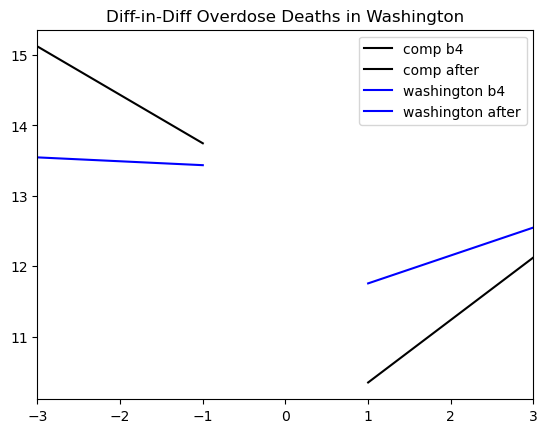

In [68]:
plt.xlim(-3, 3)
#plt.ylim(0, 500)
plt.title("Diff-in-Diff Overdose Deaths in Washington")
plt.plot(X_b41, y_pred_b41,color='k', label = "comp b4")
plt.plot(X_after1, y_pred_after1,color='k', label = "comp after")
plt.plot(X_b4, y_pred_b4,color='b', label = "washington b4")
plt.plot(X_after, y_pred_after,color='b', label = "washington after")
plt.legend()
plt.show()

In [104]:
# new method after working more with reshaping exercises
# using statsmodels now, wrapping stuff in functions
# thinking it could be easier to break it down by task

## Helper functions

1) vertical_line()
    - takes in a year and plots a vertical line at that year
2) get_charts()
    - takes in two dataframes (one for before policy, one for after)
    - returns chart for each
    - not much utility by itself - used as a parameter for our get_fit() function

In [51]:
def vertical_line(year):
    """Function to plot a vertical line at year of policy implementation"""
    line = alt.Chart(pd.DataFrame({
    'Date': [year],
    'color': ["black"]
    })).mark_rule().encode(
    x='Date:Q', # use q for "quantitative" - as per altair docs
    color=alt.Color('color:N', scale=None)
    )

    return line

In [52]:
# test function
vertical_line(2009)

alt.Chart(...)

In [53]:
def get_charts(b4, after, title_b4, title_after):
    """
    Function to plot the pre and post charts.
    Will not use in final plot - used as a baseline for our fit charts later.

    """

    base_before = (
        alt.Chart(b4)
        .mark_point()
        .encode(
            y=alt.Y("overdose_per_100k", scale=alt.Scale(zero=False)),
            x=alt.X("year relative to policy", scale=alt.Scale(zero=False)),
        )
        .properties(title=title_b4)
    )

    base_after = (
        alt.Chart(after)
        .mark_point()
        .encode(
            y=alt.Y("overdose_per_100k", scale=alt.Scale(zero=False)),
            x=alt.X("year relative to policy", scale=alt.Scale(zero=False)),
        )
        .properties(title=title_after)
    )

    return base_before, base_after

In [54]:
# test the function
# may remove title parameters later - not really necessary as we aren't plotting this part in our final analysis
# however, if we can't add a title to our fit/regression line charts, we may need to add them here
base_before, base_after = get_charts(b4 = wa_b4, after = wa_after, title_b4 = "deaths before policy", title_after="deaths after policy")
base_before + base_after

alt.LayerChart(...)

In [55]:
def get_fits(chart_b4, chart_after):
    """
    Function to plot the regression lines for the pre and post charts.
    """

    fit_wa_b4 = (
    chart_b4.transform_regression("year relative to policy", "overdose_per_100k")
    .mark_line()
    .encode(color=alt.value("red"))
    )


    fit_wa_after = (
    chart_after.transform_regression("year relative to policy", "overdose_per_100k")
    .mark_line()
    .encode(color=alt.value("red"))
    )

    return fit_wa_b4, fit_wa_after

In [56]:
# test function
fit_b4, fit_after = get_fits(chart_b4 = base_before, chart_after = base_after)
fit_b4 + fit_after

alt.LayerChart(...)

In [57]:
band_b4 = alt.Chart(wa_b4).mark_errorband(extent='ci').encode(
    x=alt.X('Year'),
    y=alt.Y('overdose_per_100k'))


band_after = alt.Chart(wa_after).mark_errorband(extent='ci').encode(
    x=alt.X('Year'),
    y=alt.Y('overdose_per_100k'))

In [59]:
fit_b4 + fit_after
# fit_b4 + fit_after + error_bars

alt.LayerChart(...)

In [60]:
error_bars = base_before.mark_rule().encode(
    x='ci0(overdose_per_100k):Q',
    x2='ci1(overdose_per_100k):Q',
)


In [61]:
error_bars

alt.Chart(...)

In [62]:
band = alt.Chart(base_before).mark_area(
    opacity=0.5
).encode(
    x='overdose_per_100k:Q',
    y='lower:N',
    y2='upper:N'
)

In [63]:
band

/Users/wzl20/opt/miniconda3/lib/python3.10/site-packages/altair/vegalite/v4/api.py:101: UserWarning: data of type <class 'altair.vegalite.v4.api.Chart'> not recognized


SchemaValidationError: Invalid specification

        altair.vegalite.v4.api.Chart->0, validating 'anyOf'

        {'data': {'name': 'data-17a89e17f5bfced4a79b7918029a5edb'}, 'mark': 'point', 'encoding': {'x': {'field': 'year relative to policy', 'scale': {'zero': False}, 'type': 'quantitative'}, 'y': {'field': 'overdose_per_100k', 'scale': {'zero': False}, 'type': 'quantitative'}}, 'title': 'deaths before policy'} is not valid under any of the given schemas
        

alt.Chart(...)

In [64]:
mean_points = alt.Chart(wa_b4).mark_circle(color='black').encode(
    alt.X("overdoses_per_100k:Q", bin=True),
    y='year relative to policy:Q',
)

error_bars = alt.Chart(wa_after).mark_errorbar(extent='ci').encode(
    alt.X("overdoses_per_100k:Q", bin=True),
    y='year relative to policy:Q',
)

In [65]:
mean_points + error_bars

alt.LayerChart(...)

In [66]:
fit_b4 + fit_after + error_bars

alt.LayerChart(...)